In [1]:
from models.adapters.base import BaseAdapter
from models.selector import FilterSelector
from models.quantization import conv2d_outter, conv2d_core
from models.selector import FilterSelector, FilterSelectorCombination, FilterSelectorCombinations
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
import numpy as np

# Disable LaTeX rendering
plt.rc('text', usetex=True)

data_store = Path("../../data_store/lenet")
data_store.mkdir(exist_ok=True, parents=True)
loaded = False
sns.set_theme(context="paper", style="whitegrid", rc={"text.usetex" : True})
sns.set_palette("deep")
sns.color_palette("deep")

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [4]:
adapter = BaseAdapter.load_base_model("qat_quantized_lenet", "./trained_models/qat.quantized_lenet.pth")

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\torch\ao\quantization\observer.py:1207: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\torch\_utils.py:376: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [5]:
data = []
# while not data or data[-1][2][1] >= 0.75:
for e in range(-128, 127, 1):
    adapter = BaseAdapter.load_base_model("qat_quantized_lenet", "qat.quantized_lenet.pth")
    assert isinstance(adapter, BaseAdapter)
    for layer in ["conv1", "conv2"]:
        weights = adapter.get_train_weights(layer)
        combinations = FilterSelectorCombinations.all_weights(layer)
        weights += e
        adapter.inject_weights([weights.flatten()], combinations, inline=True)
    top_k, avg_loss = adapter.evaluate(top=[1, 5], include_loss=True, num_workers=4, num_proc=1, batch_size=40)
    data.append([e] + list(top_k.values()) + [avg_loss])
    
loaded = True
    

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\torch\ao\quantization\observer.py:1207: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 24.6031, Acc: 0.099500, Top-5: 0.494000: 100%|██████████| 250/250 [00:14<00:00, 17.64batch/s]


Loss: 24.6031, Acc: 0.099500, Top-5: 0.494000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 23.3512, Acc: 0.087900, Top-5: 0.505800: 100%|██████████| 250/250 [00:13<00:00, 18.02batch/s]


Loss: 23.3512, Acc: 0.087900, Top-5: 0.505800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 22.9721, Acc: 0.065400, Top-5: 0.509100: 100%|██████████| 250/250 [00:14<00:00, 17.74batch/s]


Loss: 22.9721, Acc: 0.065400, Top-5: 0.509100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 24.7177, Acc: 0.032500, Top-5: 0.452800: 100%|██████████| 250/250 [00:15<00:00, 16.40batch/s]


Loss: 24.7177, Acc: 0.032500, Top-5: 0.452800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 25.0267, Acc: 0.067700, Top-5: 0.444900: 100%|██████████| 250/250 [00:25<00:00,  9.97batch/s]


Loss: 25.0267, Acc: 0.067700, Top-5: 0.444900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 22.8498, Acc: 0.081900, Top-5: 0.468400: 100%|██████████| 250/250 [00:19<00:00, 12.91batch/s]


Loss: 22.8498, Acc: 0.081900, Top-5: 0.468400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 21.7858, Acc: 0.073300, Top-5: 0.469200: 100%|██████████| 250/250 [00:18<00:00, 13.88batch/s]


Loss: 21.7858, Acc: 0.073300, Top-5: 0.469200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 22.0782, Acc: 0.080600, Top-5: 0.496200: 100%|██████████| 250/250 [00:19<00:00, 12.96batch/s]


Loss: 22.0782, Acc: 0.080600, Top-5: 0.496200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 18.7983, Acc: 0.176600, Top-5: 0.584900: 100%|██████████| 250/250 [00:21<00:00, 11.76batch/s]


Loss: 18.7983, Acc: 0.176600, Top-5: 0.584900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 15.3634, Acc: 0.204800, Top-5: 0.627700: 100%|██████████| 250/250 [00:19<00:00, 12.63batch/s]


Loss: 15.3634, Acc: 0.204800, Top-5: 0.627700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 13.5493, Acc: 0.188900, Top-5: 0.635000: 100%|██████████| 250/250 [00:17<00:00, 14.37batch/s]


Loss: 13.5493, Acc: 0.188900, Top-5: 0.635000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 10.7885, Acc: 0.187000, Top-5: 0.627000: 100%|██████████| 250/250 [00:18<00:00, 13.83batch/s]


Loss: 10.7885, Acc: 0.187000, Top-5: 0.627000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 11.2294, Acc: 0.214200, Top-5: 0.612500: 100%|██████████| 250/250 [00:18<00:00, 13.18batch/s]


Loss: 11.2294, Acc: 0.214200, Top-5: 0.612500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 7.6865, Acc: 0.261500, Top-5: 0.625000: 100%|██████████| 250/250 [00:17<00:00, 14.42batch/s]


Loss: 7.6865, Acc: 0.261500, Top-5: 0.625000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 6.3364, Acc: 0.251900, Top-5: 0.628300: 100%|██████████| 250/250 [00:17<00:00, 14.22batch/s]


Loss: 6.3364, Acc: 0.251900, Top-5: 0.628300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 5.9215, Acc: 0.231400, Top-5: 0.604700: 100%|██████████| 250/250 [00:17<00:00, 14.33batch/s]


Loss: 5.9215, Acc: 0.231400, Top-5: 0.604700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 7.4123, Acc: 0.203700, Top-5: 0.593000: 100%|██████████| 250/250 [00:17<00:00, 14.03batch/s]


Loss: 7.4123, Acc: 0.203700, Top-5: 0.593000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 8.1056, Acc: 0.217400, Top-5: 0.614900: 100%|██████████| 250/250 [00:17<00:00, 14.48batch/s]


Loss: 8.1056, Acc: 0.217400, Top-5: 0.614900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 5.6008, Acc: 0.187700, Top-5: 0.621100: 100%|██████████| 250/250 [00:17<00:00, 14.41batch/s]


Loss: 5.6008, Acc: 0.187700, Top-5: 0.621100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 3.2043, Acc: 0.208700, Top-5: 0.626000: 100%|██████████| 250/250 [00:18<00:00, 13.69batch/s]


Loss: 3.2043, Acc: 0.208700, Top-5: 0.626000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 3.2697, Acc: 0.196000, Top-5: 0.614800: 100%|██████████| 250/250 [00:17<00:00, 14.14batch/s]


Loss: 3.2697, Acc: 0.196000, Top-5: 0.614800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 3.2919, Acc: 0.161300, Top-5: 0.575800: 100%|██████████| 250/250 [00:17<00:00, 14.52batch/s]


Loss: 3.2919, Acc: 0.161300, Top-5: 0.575800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 4.1657, Acc: 0.168400, Top-5: 0.534300: 100%|██████████| 250/250 [00:16<00:00, 15.07batch/s]


Loss: 4.1657, Acc: 0.168400, Top-5: 0.534300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 3.2912, Acc: 0.167000, Top-5: 0.533800: 100%|██████████| 250/250 [00:16<00:00, 14.97batch/s]


Loss: 3.2912, Acc: 0.167000, Top-5: 0.533800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.7154, Acc: 0.149400, Top-5: 0.543900: 100%|██████████| 250/250 [00:19<00:00, 12.95batch/s]


Loss: 2.7154, Acc: 0.149400, Top-5: 0.543900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.6763, Acc: 0.141400, Top-5: 0.545800: 100%|██████████| 250/250 [00:18<00:00, 13.42batch/s]


Loss: 2.6763, Acc: 0.141400, Top-5: 0.545800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.4343, Acc: 0.136600, Top-5: 0.588900: 100%|██████████| 250/250 [00:17<00:00, 13.90batch/s]


Loss: 2.4343, Acc: 0.136600, Top-5: 0.588900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.4256, Acc: 0.164000, Top-5: 0.585900: 100%|██████████| 250/250 [00:17<00:00, 14.08batch/s]


Loss: 2.4256, Acc: 0.164000, Top-5: 0.585900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3356, Acc: 0.134400, Top-5: 0.585500: 100%|██████████| 250/250 [00:17<00:00, 14.17batch/s]


Loss: 2.3356, Acc: 0.134400, Top-5: 0.585500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3922, Acc: 0.103300, Top-5: 0.529600: 100%|██████████| 250/250 [00:17<00:00, 14.20batch/s]


Loss: 2.3922, Acc: 0.103300, Top-5: 0.529600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3138, Acc: 0.110600, Top-5: 0.540800: 100%|██████████| 250/250 [00:17<00:00, 14.19batch/s]


Loss: 2.3138, Acc: 0.110600, Top-5: 0.540800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3147, Acc: 0.123500, Top-5: 0.542800: 100%|██████████| 250/250 [00:20<00:00, 12.26batch/s]


Loss: 2.3147, Acc: 0.123500, Top-5: 0.542800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3165, Acc: 0.097900, Top-5: 0.503500: 100%|██████████| 250/250 [00:17<00:00, 14.16batch/s]


Loss: 2.3165, Acc: 0.097900, Top-5: 0.503500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3104, Acc: 0.083100, Top-5: 0.517000: 100%|██████████| 250/250 [00:17<00:00, 14.17batch/s]


Loss: 2.3104, Acc: 0.083100, Top-5: 0.517000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3205, Acc: 0.077400, Top-5: 0.524800: 100%|██████████| 250/250 [00:17<00:00, 14.39batch/s]


Loss: 2.3205, Acc: 0.077400, Top-5: 0.524800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3306, Acc: 0.074300, Top-5: 0.510500: 100%|██████████| 250/250 [00:17<00:00, 14.29batch/s]


Loss: 2.3306, Acc: 0.074300, Top-5: 0.510500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3045, Acc: 0.101300, Top-5: 0.515200: 100%|██████████| 250/250 [00:18<00:00, 13.74batch/s]


Loss: 2.3045, Acc: 0.101300, Top-5: 0.515200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3085, Acc: 0.097000, Top-5: 0.510900: 100%|██████████| 250/250 [00:17<00:00, 14.42batch/s]


Loss: 2.3085, Acc: 0.097000, Top-5: 0.510900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513700: 100%|██████████| 250/250 [00:17<00:00, 14.45batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3028, Acc: 0.098000, Top-5: 0.513800: 100%|██████████| 250/250 [00:17<00:00, 14.32batch/s]


Loss: 2.3028, Acc: 0.098000, Top-5: 0.513800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3029, Acc: 0.097900, Top-5: 0.513600: 100%|██████████| 250/250 [00:17<00:00, 14.23batch/s]


Loss: 2.3029, Acc: 0.097900, Top-5: 0.513600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3028, Acc: 0.098000, Top-5: 0.513700: 100%|██████████| 250/250 [00:17<00:00, 14.48batch/s]


Loss: 2.3028, Acc: 0.098000, Top-5: 0.513700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.097600, Top-5: 0.514500: 100%|██████████| 250/250 [00:19<00:00, 13.05batch/s]


Loss: 2.3026, Acc: 0.097600, Top-5: 0.514500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3020, Acc: 0.098000, Top-5: 0.515200: 100%|██████████| 250/250 [00:18<00:00, 13.65batch/s]


Loss: 2.3020, Acc: 0.098000, Top-5: 0.515200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.37batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.097900, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 13.94batch/s]


Loss: 2.3026, Acc: 0.097900, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.097900, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.26batch/s]


Loss: 2.3026, Acc: 0.097900, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.097900, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.50batch/s]


Loss: 2.3026, Acc: 0.097900, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 13.95batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.24batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.097900, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.48batch/s]


Loss: 2.3026, Acc: 0.097900, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 13.97batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.18batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:18<00:00, 13.81batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.32batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:18<00:00, 13.51batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.13batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.24batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.21batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:18<00:00, 13.49batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.37batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.20batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:18<00:00, 13.17batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.32batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.23batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 13.90batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 13.93batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.30batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.35batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.20batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.79batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.96batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.95batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.94batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 15.27batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.94batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.47batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.97batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.90batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.70batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.64batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.92batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.97batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513800: 100%|██████████| 250/250 [00:17<00:00, 14.44batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.40batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3025, Acc: 0.098100, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.97batch/s]


Loss: 2.3025, Acc: 0.098100, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3025, Acc: 0.098100, Top-5: 0.514000: 100%|██████████| 250/250 [00:16<00:00, 14.83batch/s]


Loss: 2.3025, Acc: 0.098100, Top-5: 0.514000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3025, Acc: 0.098100, Top-5: 0.514000: 100%|██████████| 250/250 [00:17<00:00, 14.47batch/s]


Loss: 2.3025, Acc: 0.098100, Top-5: 0.514000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098000, Top-5: 0.514000: 100%|██████████| 250/250 [00:16<00:00, 15.02batch/s]


Loss: 2.3026, Acc: 0.098000, Top-5: 0.514000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3027, Acc: 0.098000, Top-5: 0.513700: 100%|██████████| 250/250 [00:16<00:00, 14.90batch/s]


Loss: 2.3027, Acc: 0.098000, Top-5: 0.513700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3027, Acc: 0.098000, Top-5: 0.513400: 100%|██████████| 250/250 [00:17<00:00, 14.70batch/s]


Loss: 2.3027, Acc: 0.098000, Top-5: 0.513400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3026, Acc: 0.098300, Top-5: 0.513500: 100%|██████████| 250/250 [00:16<00:00, 14.97batch/s]


Loss: 2.3026, Acc: 0.098300, Top-5: 0.513500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3027, Acc: 0.098100, Top-5: 0.513700: 100%|██████████| 250/250 [00:16<00:00, 14.78batch/s]


Loss: 2.3027, Acc: 0.098100, Top-5: 0.513700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3028, Acc: 0.098100, Top-5: 0.513600: 100%|██████████| 250/250 [00:17<00:00, 14.15batch/s]


Loss: 2.3028, Acc: 0.098100, Top-5: 0.513600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3029, Acc: 0.098200, Top-5: 0.512900: 100%|██████████| 250/250 [00:16<00:00, 14.83batch/s]


Loss: 2.3029, Acc: 0.098200, Top-5: 0.512900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3025, Acc: 0.098100, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.97batch/s]


Loss: 2.3025, Acc: 0.098100, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3024, Acc: 0.098400, Top-5: 0.513900: 100%|██████████| 250/250 [00:16<00:00, 14.93batch/s]


Loss: 2.3024, Acc: 0.098400, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3024, Acc: 0.098400, Top-5: 0.513700: 100%|██████████| 250/250 [00:17<00:00, 14.61batch/s]


Loss: 2.3024, Acc: 0.098400, Top-5: 0.513700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3022, Acc: 0.099800, Top-5: 0.513300: 100%|██████████| 250/250 [00:16<00:00, 14.99batch/s]


Loss: 2.3022, Acc: 0.099800, Top-5: 0.513300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3016, Acc: 0.100900, Top-5: 0.513600: 100%|██████████| 250/250 [00:16<00:00, 14.87batch/s]


Loss: 2.3016, Acc: 0.100900, Top-5: 0.513600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3002, Acc: 0.102900, Top-5: 0.513200: 100%|██████████| 250/250 [00:16<00:00, 14.89batch/s]


Loss: 2.3002, Acc: 0.102900, Top-5: 0.513200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3012, Acc: 0.100200, Top-5: 0.514300: 100%|██████████| 250/250 [00:16<00:00, 15.00batch/s]


Loss: 2.3012, Acc: 0.100200, Top-5: 0.514300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3025, Acc: 0.098200, Top-5: 0.513900: 100%|██████████| 250/250 [00:17<00:00, 14.62batch/s]


Loss: 2.3025, Acc: 0.098200, Top-5: 0.513900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3019, Acc: 0.098400, Top-5: 0.514300: 100%|██████████| 250/250 [00:16<00:00, 14.99batch/s]


Loss: 2.3019, Acc: 0.098400, Top-5: 0.514300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.3012, Acc: 0.099000, Top-5: 0.514300: 100%|██████████| 250/250 [00:18<00:00, 13.80batch/s]


Loss: 2.3012, Acc: 0.099000, Top-5: 0.514300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.2985, Acc: 0.102200, Top-5: 0.516900: 100%|██████████| 250/250 [00:16<00:00, 14.88batch/s]


Loss: 2.2985, Acc: 0.102200, Top-5: 0.516900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.2943, Acc: 0.105400, Top-5: 0.522000: 100%|██████████| 250/250 [00:16<00:00, 14.97batch/s]


Loss: 2.2943, Acc: 0.105400, Top-5: 0.522000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.2832, Acc: 0.115800, Top-5: 0.533400: 100%|██████████| 250/250 [00:16<00:00, 14.83batch/s]


Loss: 2.2832, Acc: 0.115800, Top-5: 0.533400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.2584, Acc: 0.135700, Top-5: 0.563600: 100%|██████████| 250/250 [00:17<00:00, 14.42batch/s]


Loss: 2.2584, Acc: 0.135700, Top-5: 0.563600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.2184, Acc: 0.157400, Top-5: 0.615800: 100%|██████████| 250/250 [00:16<00:00, 14.82batch/s]


Loss: 2.2184, Acc: 0.157400, Top-5: 0.615800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.1939, Acc: 0.172700, Top-5: 0.638200: 100%|██████████| 250/250 [00:16<00:00, 14.93batch/s]


Loss: 2.1939, Acc: 0.172700, Top-5: 0.638200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.1502, Acc: 0.197400, Top-5: 0.684000: 100%|██████████| 250/250 [00:17<00:00, 14.66batch/s]


Loss: 2.1502, Acc: 0.197400, Top-5: 0.684000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 2.0618, Acc: 0.257300, Top-5: 0.740300: 100%|██████████| 250/250 [00:17<00:00, 14.66batch/s]


Loss: 2.0618, Acc: 0.257300, Top-5: 0.740300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 1.9382, Acc: 0.341200, Top-5: 0.791200: 100%|██████████| 250/250 [00:16<00:00, 14.94batch/s]


Loss: 1.9382, Acc: 0.341200, Top-5: 0.791200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 1.7638, Acc: 0.448900, Top-5: 0.836300: 100%|██████████| 250/250 [00:16<00:00, 14.75batch/s]


Loss: 1.7638, Acc: 0.448900, Top-5: 0.836300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 1.5395, Acc: 0.585100, Top-5: 0.899500: 100%|██████████| 250/250 [00:16<00:00, 14.72batch/s]


Loss: 1.5395, Acc: 0.585100, Top-5: 0.899500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 1.2123, Acc: 0.699200, Top-5: 0.945100: 100%|██████████| 250/250 [00:16<00:00, 14.85batch/s]


Loss: 1.2123, Acc: 0.699200, Top-5: 0.945100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.8530, Acc: 0.792400, Top-5: 0.975100: 100%|██████████| 250/250 [00:17<00:00, 14.57batch/s]


Loss: 0.8530, Acc: 0.792400, Top-5: 0.975100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.5759, Acc: 0.858500, Top-5: 0.985900: 100%|██████████| 250/250 [00:16<00:00, 14.87batch/s]


Loss: 0.5759, Acc: 0.858500, Top-5: 0.985900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.3691, Acc: 0.905400, Top-5: 0.993400: 100%|██████████| 250/250 [00:16<00:00, 14.84batch/s]


Loss: 0.3691, Acc: 0.905400, Top-5: 0.993400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.2383, Acc: 0.933600, Top-5: 0.997300: 100%|██████████| 250/250 [00:17<00:00, 14.59batch/s]


Loss: 0.2383, Acc: 0.933600, Top-5: 0.997300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.1686, Acc: 0.950000, Top-5: 0.998300: 100%|██████████| 250/250 [00:17<00:00, 14.32batch/s]


Loss: 0.1686, Acc: 0.950000, Top-5: 0.998300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.1295, Acc: 0.960000, Top-5: 0.998500: 100%|██████████| 250/250 [00:16<00:00, 14.92batch/s]


Loss: 0.1295, Acc: 0.960000, Top-5: 0.998500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.0717, Acc: 0.977600, Top-5: 0.999800: 100%|██████████| 250/250 [00:17<00:00, 14.65batch/s]


Loss: 0.0717, Acc: 0.977600, Top-5: 0.999800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.0493, Acc: 0.986700, Top-5: 0.999900: 100%|██████████| 250/250 [00:17<00:00, 13.91batch/s]


Loss: 0.0493, Acc: 0.986700, Top-5: 0.999900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.0449, Acc: 0.987600, Top-5: 0.999900: 100%|██████████| 250/250 [00:17<00:00, 14.32batch/s]


Loss: 0.0449, Acc: 0.987600, Top-5: 0.999900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.0414, Acc: 0.988500, Top-5: 0.999900: 100%|██████████| 250/250 [00:17<00:00, 14.48batch/s]


Loss: 0.0414, Acc: 0.988500, Top-5: 0.999900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.0329, Acc: 0.990900, Top-5: 1.000000: 100%|██████████| 250/250 [00:17<00:00, 14.38batch/s]


Loss: 0.0329, Acc: 0.990900, Top-5: 1.000000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.0320, Acc: 0.991600, Top-5: 1.000000: 100%|██████████| 250/250 [00:19<00:00, 12.98batch/s]


Loss: 0.0320, Acc: 0.991600, Top-5: 1.000000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.0730, Acc: 0.977400, Top-5: 1.000000: 100%|██████████| 250/250 [00:17<00:00, 14.65batch/s]


Loss: 0.0730, Acc: 0.977400, Top-5: 1.000000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.0925, Acc: 0.972600, Top-5: 0.999900: 100%|██████████| 250/250 [00:17<00:00, 14.66batch/s]


Loss: 0.0925, Acc: 0.972600, Top-5: 0.999900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.1749, Acc: 0.951300, Top-5: 0.999800: 100%|██████████| 250/250 [00:17<00:00, 14.64batch/s]


Loss: 0.1749, Acc: 0.951300, Top-5: 0.999800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.1747, Acc: 0.950200, Top-5: 0.999600: 100%|██████████| 250/250 [00:17<00:00, 14.68batch/s]


Loss: 0.1747, Acc: 0.950200, Top-5: 0.999600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.2887, Acc: 0.924500, Top-5: 0.999700: 100%|██████████| 250/250 [00:16<00:00, 14.97batch/s]


Loss: 0.2887, Acc: 0.924500, Top-5: 0.999700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.4200, Acc: 0.901100, Top-5: 0.999600: 100%|██████████| 250/250 [00:16<00:00, 14.94batch/s]


Loss: 0.4200, Acc: 0.901100, Top-5: 0.999600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 0.8369, Acc: 0.817400, Top-5: 0.999300: 100%|██████████| 250/250 [00:17<00:00, 14.69batch/s]


Loss: 0.8369, Acc: 0.817400, Top-5: 0.999300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 1.1382, Acc: 0.782100, Top-5: 0.999100: 100%|██████████| 250/250 [00:17<00:00, 14.39batch/s]


Loss: 1.1382, Acc: 0.782100, Top-5: 0.999100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 1.4768, Acc: 0.747400, Top-5: 0.999000: 100%|██████████| 250/250 [00:16<00:00, 14.96batch/s]


Loss: 1.4768, Acc: 0.747400, Top-5: 0.999000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 5.5363, Acc: 0.517200, Top-5: 0.945500: 100%|██████████| 250/250 [00:17<00:00, 14.40batch/s]


Loss: 5.5363, Acc: 0.517200, Top-5: 0.945500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 6.1592, Acc: 0.487300, Top-5: 0.945300: 100%|██████████| 250/250 [00:19<00:00, 12.90batch/s]


Loss: 6.1592, Acc: 0.487300, Top-5: 0.945300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 6.7677, Acc: 0.465900, Top-5: 0.931700: 100%|██████████| 250/250 [00:16<00:00, 14.72batch/s]


Loss: 6.7677, Acc: 0.465900, Top-5: 0.931700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 6.7054, Acc: 0.414700, Top-5: 0.931400: 100%|██████████| 250/250 [00:17<00:00, 14.66batch/s]


Loss: 6.7054, Acc: 0.414700, Top-5: 0.931400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 7.3959, Acc: 0.392100, Top-5: 0.926200: 100%|██████████| 250/250 [00:17<00:00, 14.69batch/s]


Loss: 7.3959, Acc: 0.392100, Top-5: 0.926200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 8.1145, Acc: 0.367900, Top-5: 0.925400: 100%|██████████| 250/250 [00:17<00:00, 14.69batch/s]


Loss: 8.1145, Acc: 0.367900, Top-5: 0.925400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 8.7190, Acc: 0.347700, Top-5: 0.913600: 100%|██████████| 250/250 [00:16<00:00, 14.90batch/s]


Loss: 8.7190, Acc: 0.347700, Top-5: 0.913600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 9.6458, Acc: 0.323600, Top-5: 0.903300: 100%|██████████| 250/250 [00:17<00:00, 14.38batch/s]


Loss: 9.6458, Acc: 0.323600, Top-5: 0.903300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 11.6471, Acc: 0.267900, Top-5: 0.847200: 100%|██████████| 250/250 [00:16<00:00, 14.72batch/s]


Loss: 11.6471, Acc: 0.267900, Top-5: 0.847200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 13.1705, Acc: 0.247200, Top-5: 0.830200: 100%|██████████| 250/250 [00:16<00:00, 14.73batch/s]


Loss: 13.1705, Acc: 0.247200, Top-5: 0.830200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 13.0669, Acc: 0.262600, Top-5: 0.830500: 100%|██████████| 250/250 [00:17<00:00, 14.60batch/s]


Loss: 13.0669, Acc: 0.262600, Top-5: 0.830500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 13.7613, Acc: 0.255700, Top-5: 0.826000: 100%|██████████| 250/250 [00:17<00:00, 14.68batch/s]


Loss: 13.7613, Acc: 0.255700, Top-5: 0.826000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 14.9198, Acc: 0.228400, Top-5: 0.803300: 100%|██████████| 250/250 [00:16<00:00, 14.91batch/s]


Loss: 14.9198, Acc: 0.228400, Top-5: 0.803300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 15.4127, Acc: 0.226900, Top-5: 0.793500: 100%|██████████| 250/250 [00:17<00:00, 14.65batch/s]


Loss: 15.4127, Acc: 0.226900, Top-5: 0.793500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 18.4157, Acc: 0.198600, Top-5: 0.770400: 100%|██████████| 250/250 [00:16<00:00, 14.91batch/s]


Loss: 18.4157, Acc: 0.198600, Top-5: 0.770400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 20.8998, Acc: 0.189100, Top-5: 0.753500: 100%|██████████| 250/250 [00:16<00:00, 14.72batch/s]


Loss: 20.8998, Acc: 0.189100, Top-5: 0.753500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 21.5300, Acc: 0.193300, Top-5: 0.725100: 100%|██████████| 250/250 [00:16<00:00, 14.94batch/s]


Loss: 21.5300, Acc: 0.193300, Top-5: 0.725100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 27.5294, Acc: 0.178700, Top-5: 0.691900: 100%|██████████| 250/250 [00:17<00:00, 14.31batch/s]


Loss: 27.5294, Acc: 0.178700, Top-5: 0.691900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 28.4315, Acc: 0.178700, Top-5: 0.685000: 100%|██████████| 250/250 [00:17<00:00, 14.34batch/s]


Loss: 28.4315, Acc: 0.178700, Top-5: 0.685000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 27.5076, Acc: 0.184700, Top-5: 0.672700: 100%|██████████| 250/250 [00:17<00:00, 14.69batch/s]


Loss: 27.5076, Acc: 0.184700, Top-5: 0.672700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 28.0713, Acc: 0.183900, Top-5: 0.671500: 100%|██████████| 250/250 [00:16<00:00, 14.72batch/s]


Loss: 28.0713, Acc: 0.183900, Top-5: 0.671500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 28.9589, Acc: 0.183800, Top-5: 0.668500: 100%|██████████| 250/250 [00:17<00:00, 14.12batch/s]


Loss: 28.9589, Acc: 0.183800, Top-5: 0.668500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 29.5335, Acc: 0.183700, Top-5: 0.666000: 100%|██████████| 250/250 [00:18<00:00, 13.32batch/s]


Loss: 29.5335, Acc: 0.183700, Top-5: 0.666000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 30.4188, Acc: 0.180500, Top-5: 0.659000: 100%|██████████| 250/250 [00:13<00:00, 18.14batch/s]


Loss: 30.4188, Acc: 0.180500, Top-5: 0.659000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 31.0397, Acc: 0.180100, Top-5: 0.655100: 100%|██████████| 250/250 [00:18<00:00, 13.21batch/s]


Loss: 31.0397, Acc: 0.180100, Top-5: 0.655100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 36.5522, Acc: 0.176000, Top-5: 0.651800: 100%|██████████| 250/250 [00:14<00:00, 17.73batch/s]


Loss: 36.5522, Acc: 0.176000, Top-5: 0.651800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 36.9221, Acc: 0.167700, Top-5: 0.634200: 100%|██████████| 250/250 [00:13<00:00, 17.87batch/s]


Loss: 36.9221, Acc: 0.167700, Top-5: 0.634200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 37.6799, Acc: 0.166800, Top-5: 0.627700: 100%|██████████| 250/250 [00:15<00:00, 16.53batch/s]


Loss: 37.6799, Acc: 0.166800, Top-5: 0.627700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 39.0891, Acc: 0.159000, Top-5: 0.628500: 100%|██████████| 250/250 [00:13<00:00, 18.74batch/s]


Loss: 39.0891, Acc: 0.159000, Top-5: 0.628500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 38.4821, Acc: 0.164400, Top-5: 0.597900: 100%|██████████| 250/250 [00:13<00:00, 18.63batch/s]


Loss: 38.4821, Acc: 0.164400, Top-5: 0.597900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 39.4610, Acc: 0.161100, Top-5: 0.586700: 100%|██████████| 250/250 [00:13<00:00, 18.67batch/s]


Loss: 39.4610, Acc: 0.161100, Top-5: 0.586700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 38.7742, Acc: 0.161100, Top-5: 0.588200: 100%|██████████| 250/250 [00:13<00:00, 18.80batch/s]


Loss: 38.7742, Acc: 0.161100, Top-5: 0.588200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 38.2359, Acc: 0.159500, Top-5: 0.584700: 100%|██████████| 250/250 [00:13<00:00, 18.62batch/s]


Loss: 38.2359, Acc: 0.159500, Top-5: 0.584700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 38.4398, Acc: 0.158100, Top-5: 0.581300: 100%|██████████| 250/250 [00:13<00:00, 18.98batch/s]


Loss: 38.4398, Acc: 0.158100, Top-5: 0.581300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 38.8866, Acc: 0.159700, Top-5: 0.573500: 100%|██████████| 250/250 [00:13<00:00, 19.02batch/s]


Loss: 38.8866, Acc: 0.159700, Top-5: 0.573500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 38.8126, Acc: 0.161000, Top-5: 0.559000: 100%|██████████| 250/250 [00:13<00:00, 19.03batch/s]


Loss: 38.8126, Acc: 0.161000, Top-5: 0.559000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 42.3043, Acc: 0.151900, Top-5: 0.525400: 100%|██████████| 250/250 [00:13<00:00, 18.68batch/s]


Loss: 42.3043, Acc: 0.151900, Top-5: 0.525400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 41.5026, Acc: 0.153800, Top-5: 0.525100: 100%|██████████| 250/250 [00:13<00:00, 18.18batch/s]


Loss: 41.5026, Acc: 0.153800, Top-5: 0.525100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 42.1554, Acc: 0.148500, Top-5: 0.499200: 100%|██████████| 250/250 [00:13<00:00, 18.75batch/s]


Loss: 42.1554, Acc: 0.148500, Top-5: 0.499200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 45.3770, Acc: 0.162200, Top-5: 0.529300: 100%|██████████| 250/250 [00:13<00:00, 18.04batch/s]


Loss: 45.3770, Acc: 0.162200, Top-5: 0.529300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 45.7256, Acc: 0.158800, Top-5: 0.528200: 100%|██████████| 250/250 [00:13<00:00, 19.02batch/s]


Loss: 45.7256, Acc: 0.158800, Top-5: 0.528200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 45.6441, Acc: 0.159000, Top-5: 0.503200: 100%|██████████| 250/250 [00:13<00:00, 18.78batch/s]


Loss: 45.6441, Acc: 0.159000, Top-5: 0.503200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 46.9051, Acc: 0.158000, Top-5: 0.517700: 100%|██████████| 250/250 [00:13<00:00, 18.30batch/s]


Loss: 46.9051, Acc: 0.158000, Top-5: 0.517700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 48.7168, Acc: 0.152300, Top-5: 0.523100: 100%|██████████| 250/250 [00:13<00:00, 18.83batch/s]


Loss: 48.7168, Acc: 0.152300, Top-5: 0.523100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 48.2134, Acc: 0.146300, Top-5: 0.519900: 100%|██████████| 250/250 [00:13<00:00, 19.02batch/s]


Loss: 48.2134, Acc: 0.146300, Top-5: 0.519900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 48.2370, Acc: 0.138600, Top-5: 0.512700: 100%|██████████| 250/250 [00:13<00:00, 18.57batch/s]


Loss: 48.2370, Acc: 0.138600, Top-5: 0.512700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 48.5945, Acc: 0.130400, Top-5: 0.501500: 100%|██████████| 250/250 [00:14<00:00, 17.82batch/s]


Loss: 48.5945, Acc: 0.130400, Top-5: 0.501500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 48.6692, Acc: 0.124900, Top-5: 0.497200: 100%|██████████| 250/250 [00:13<00:00, 18.66batch/s]


Loss: 48.6692, Acc: 0.124900, Top-5: 0.497200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 50.9765, Acc: 0.117700, Top-5: 0.493500: 100%|██████████| 250/250 [00:13<00:00, 18.82batch/s]


Loss: 50.9765, Acc: 0.117700, Top-5: 0.493500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 49.7126, Acc: 0.137100, Top-5: 0.517200: 100%|██████████| 250/250 [00:13<00:00, 19.11batch/s]


Loss: 49.7126, Acc: 0.137100, Top-5: 0.517200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 48.5744, Acc: 0.140700, Top-5: 0.509400: 100%|██████████| 250/250 [00:13<00:00, 18.98batch/s]


Loss: 48.5744, Acc: 0.140700, Top-5: 0.509400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 47.4515, Acc: 0.137500, Top-5: 0.517400: 100%|██████████| 250/250 [00:13<00:00, 18.48batch/s]


Loss: 47.4515, Acc: 0.137500, Top-5: 0.517400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 48.6627, Acc: 0.124000, Top-5: 0.505200: 100%|██████████| 250/250 [00:13<00:00, 18.64batch/s]


Loss: 48.6627, Acc: 0.124000, Top-5: 0.505200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 49.0315, Acc: 0.129700, Top-5: 0.520500: 100%|██████████| 250/250 [00:13<00:00, 19.03batch/s]


Loss: 49.0315, Acc: 0.129700, Top-5: 0.520500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 49.4290, Acc: 0.119500, Top-5: 0.545100: 100%|██████████| 250/250 [00:13<00:00, 19.12batch/s]


Loss: 49.4290, Acc: 0.119500, Top-5: 0.545100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 50.5309, Acc: 0.109100, Top-5: 0.572000: 100%|██████████| 250/250 [00:13<00:00, 19.09batch/s]


Loss: 50.5309, Acc: 0.109100, Top-5: 0.572000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 49.5580, Acc: 0.100800, Top-5: 0.552900: 100%|██████████| 250/250 [00:13<00:00, 18.78batch/s]


Loss: 49.5580, Acc: 0.100800, Top-5: 0.552900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 49.1618, Acc: 0.088700, Top-5: 0.549900: 100%|██████████| 250/250 [00:13<00:00, 18.52batch/s]


Loss: 49.1618, Acc: 0.088700, Top-5: 0.549900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 47.5233, Acc: 0.100800, Top-5: 0.562400: 100%|██████████| 250/250 [00:13<00:00, 18.65batch/s]


Loss: 47.5233, Acc: 0.100800, Top-5: 0.562400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 47.9760, Acc: 0.101800, Top-5: 0.551800: 100%|██████████| 250/250 [00:13<00:00, 18.46batch/s]


Loss: 47.9760, Acc: 0.101800, Top-5: 0.551800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 47.1621, Acc: 0.095500, Top-5: 0.577500: 100%|██████████| 250/250 [00:13<00:00, 18.54batch/s]


Loss: 47.1621, Acc: 0.095500, Top-5: 0.577500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 47.1656, Acc: 0.100400, Top-5: 0.574500: 100%|██████████| 250/250 [00:13<00:00, 19.03batch/s]


Loss: 47.1656, Acc: 0.100400, Top-5: 0.574500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 47.1579, Acc: 0.099000, Top-5: 0.562600: 100%|██████████| 250/250 [00:13<00:00, 19.05batch/s]


Loss: 47.1579, Acc: 0.099000, Top-5: 0.562600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 46.1680, Acc: 0.102300, Top-5: 0.561500: 100%|██████████| 250/250 [00:13<00:00, 18.54batch/s]


Loss: 46.1680, Acc: 0.102300, Top-5: 0.561500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 45.5950, Acc: 0.104300, Top-5: 0.553900: 100%|██████████| 250/250 [00:13<00:00, 19.03batch/s]


Loss: 45.5950, Acc: 0.104300, Top-5: 0.553900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 45.4972, Acc: 0.104700, Top-5: 0.555700: 100%|██████████| 250/250 [00:13<00:00, 18.61batch/s]


Loss: 45.4972, Acc: 0.104700, Top-5: 0.555700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 45.4069, Acc: 0.107200, Top-5: 0.558700: 100%|██████████| 250/250 [00:13<00:00, 18.77batch/s]


Loss: 45.4069, Acc: 0.107200, Top-5: 0.558700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 50.3873, Acc: 0.104300, Top-5: 0.571500: 100%|██████████| 250/250 [00:13<00:00, 18.65batch/s]


Loss: 50.3873, Acc: 0.104300, Top-5: 0.571500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 51.6322, Acc: 0.105500, Top-5: 0.566400: 100%|██████████| 250/250 [00:13<00:00, 18.28batch/s]


Loss: 51.6322, Acc: 0.105500, Top-5: 0.566400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 51.9723, Acc: 0.101400, Top-5: 0.560600: 100%|██████████| 250/250 [00:13<00:00, 19.04batch/s]


Loss: 51.9723, Acc: 0.101400, Top-5: 0.560600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 52.0919, Acc: 0.108300, Top-5: 0.547900: 100%|██████████| 250/250 [00:13<00:00, 18.97batch/s]


Loss: 52.0919, Acc: 0.108300, Top-5: 0.547900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 51.4713, Acc: 0.112100, Top-5: 0.530000: 100%|██████████| 250/250 [00:13<00:00, 18.82batch/s]


Loss: 51.4713, Acc: 0.112100, Top-5: 0.530000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 50.1633, Acc: 0.111800, Top-5: 0.526000: 100%|██████████| 250/250 [00:13<00:00, 19.02batch/s]


Loss: 50.1633, Acc: 0.111800, Top-5: 0.526000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 50.2508, Acc: 0.111400, Top-5: 0.523100: 100%|██████████| 250/250 [00:13<00:00, 18.80batch/s]


Loss: 50.2508, Acc: 0.111400, Top-5: 0.523100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 53.5794, Acc: 0.113700, Top-5: 0.520100: 100%|██████████| 250/250 [00:13<00:00, 18.83batch/s]


Loss: 53.5794, Acc: 0.113700, Top-5: 0.520100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 53.3658, Acc: 0.115000, Top-5: 0.526500: 100%|██████████| 250/250 [00:13<00:00, 19.07batch/s]


Loss: 53.3658, Acc: 0.115000, Top-5: 0.526500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 52.6344, Acc: 0.116200, Top-5: 0.526800: 100%|██████████| 250/250 [00:13<00:00, 19.04batch/s]


Loss: 52.6344, Acc: 0.116200, Top-5: 0.526800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 52.3583, Acc: 0.114700, Top-5: 0.523100: 100%|██████████| 250/250 [00:13<00:00, 18.57batch/s]


Loss: 52.3583, Acc: 0.114700, Top-5: 0.523100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 51.5916, Acc: 0.106900, Top-5: 0.505800: 100%|██████████| 250/250 [00:13<00:00, 18.90batch/s]


Loss: 51.5916, Acc: 0.106900, Top-5: 0.505800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 50.5805, Acc: 0.105200, Top-5: 0.494600: 100%|██████████| 250/250 [00:13<00:00, 19.03batch/s]


Loss: 50.5805, Acc: 0.105200, Top-5: 0.494600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 48.1391, Acc: 0.099900, Top-5: 0.502200: 100%|██████████| 250/250 [00:13<00:00, 18.80batch/s]


Loss: 48.1391, Acc: 0.099900, Top-5: 0.502200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 48.0592, Acc: 0.088500, Top-5: 0.492300: 100%|██████████| 250/250 [00:17<00:00, 14.25batch/s]


Loss: 48.0592, Acc: 0.088500, Top-5: 0.492300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 52.7852, Acc: 0.086400, Top-5: 0.470000: 100%|██████████| 250/250 [00:14<00:00, 17.21batch/s]


Loss: 52.7852, Acc: 0.086400, Top-5: 0.470000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 51.3320, Acc: 0.092200, Top-5: 0.482700: 100%|██████████| 250/250 [00:14<00:00, 17.35batch/s]


Loss: 51.3320, Acc: 0.092200, Top-5: 0.482700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 48.0410, Acc: 0.101800, Top-5: 0.499800: 100%|██████████| 250/250 [00:14<00:00, 16.93batch/s]


Loss: 48.0410, Acc: 0.101800, Top-5: 0.499800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 46.7675, Acc: 0.094800, Top-5: 0.501500: 100%|██████████| 250/250 [00:13<00:00, 18.26batch/s]


Loss: 46.7675, Acc: 0.094800, Top-5: 0.501500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 47.9580, Acc: 0.095500, Top-5: 0.489100: 100%|██████████| 250/250 [00:13<00:00, 18.12batch/s]


Loss: 47.9580, Acc: 0.095500, Top-5: 0.489100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 47.0799, Acc: 0.096400, Top-5: 0.491300: 100%|██████████| 250/250 [00:13<00:00, 18.76batch/s]


Loss: 47.0799, Acc: 0.096400, Top-5: 0.491300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 44.7135, Acc: 0.107600, Top-5: 0.493900: 100%|██████████| 250/250 [00:13<00:00, 19.04batch/s]


Loss: 44.7135, Acc: 0.107600, Top-5: 0.493900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 44.5235, Acc: 0.125300, Top-5: 0.498800: 100%|██████████| 250/250 [00:13<00:00, 18.92batch/s]


Loss: 44.5235, Acc: 0.125300, Top-5: 0.498800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 46.5021, Acc: 0.131500, Top-5: 0.503400: 100%|██████████| 250/250 [00:13<00:00, 18.96batch/s]


Loss: 46.5021, Acc: 0.131500, Top-5: 0.503400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 44.9715, Acc: 0.136600, Top-5: 0.506200: 100%|██████████| 250/250 [00:13<00:00, 18.31batch/s]


Loss: 44.9715, Acc: 0.136600, Top-5: 0.506200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 44.2176, Acc: 0.130100, Top-5: 0.500500: 100%|██████████| 250/250 [00:13<00:00, 18.02batch/s]


Loss: 44.2176, Acc: 0.130100, Top-5: 0.500500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 45.7793, Acc: 0.107500, Top-5: 0.506800: 100%|██████████| 250/250 [00:13<00:00, 18.96batch/s]


Loss: 45.7793, Acc: 0.107500, Top-5: 0.506800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 44.2075, Acc: 0.101500, Top-5: 0.504000: 100%|██████████| 250/250 [00:13<00:00, 18.61batch/s]


Loss: 44.2075, Acc: 0.101500, Top-5: 0.504000
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 43.1811, Acc: 0.102000, Top-5: 0.506200: 100%|██████████| 250/250 [00:13<00:00, 18.64batch/s]


Loss: 43.1811, Acc: 0.102000, Top-5: 0.506200
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 41.2516, Acc: 0.089100, Top-5: 0.504100: 100%|██████████| 250/250 [00:13<00:00, 18.54batch/s]


Loss: 41.2516, Acc: 0.089100, Top-5: 0.504100
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 45.5877, Acc: 0.066700, Top-5: 0.505700: 100%|██████████| 250/250 [00:13<00:00, 19.05batch/s]


Loss: 45.5877, Acc: 0.066700, Top-5: 0.505700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 44.4638, Acc: 0.073700, Top-5: 0.503700: 100%|██████████| 250/250 [00:13<00:00, 18.95batch/s]


Loss: 44.4638, Acc: 0.073700, Top-5: 0.503700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 44.4367, Acc: 0.079400, Top-5: 0.502600: 100%|██████████| 250/250 [00:13<00:00, 18.71batch/s]


Loss: 44.4367, Acc: 0.079400, Top-5: 0.502600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 46.5117, Acc: 0.082300, Top-5: 0.502900: 100%|██████████| 250/250 [00:13<00:00, 18.86batch/s]


Loss: 46.5117, Acc: 0.082300, Top-5: 0.502900
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 43.1291, Acc: 0.080100, Top-5: 0.502400: 100%|██████████| 250/250 [00:13<00:00, 19.05batch/s]


Loss: 43.1291, Acc: 0.080100, Top-5: 0.502400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 45.2341, Acc: 0.081000, Top-5: 0.502500: 100%|██████████| 250/250 [00:13<00:00, 18.06batch/s]


Loss: 45.2341, Acc: 0.081000, Top-5: 0.502500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 44.2568, Acc: 0.062900, Top-5: 0.502300: 100%|██████████| 250/250 [00:13<00:00, 18.58batch/s]


Loss: 44.2568, Acc: 0.062900, Top-5: 0.502300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 42.4222, Acc: 0.062000, Top-5: 0.501800: 100%|██████████| 250/250 [00:13<00:00, 18.56batch/s]


Loss: 42.4222, Acc: 0.062000, Top-5: 0.501800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 40.9543, Acc: 0.057500, Top-5: 0.501400: 100%|██████████| 250/250 [00:13<00:00, 18.75batch/s]


Loss: 40.9543, Acc: 0.057500, Top-5: 0.501400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 37.5681, Acc: 0.072200, Top-5: 0.502600: 100%|██████████| 250/250 [00:13<00:00, 18.93batch/s]


Loss: 37.5681, Acc: 0.072200, Top-5: 0.502600
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 39.2430, Acc: 0.076500, Top-5: 0.502700: 100%|██████████| 250/250 [00:13<00:00, 18.80batch/s]


Loss: 39.2430, Acc: 0.076500, Top-5: 0.502700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 37.7255, Acc: 0.068500, Top-5: 0.502700: 100%|██████████| 250/250 [00:13<00:00, 18.78batch/s]


Loss: 37.7255, Acc: 0.068500, Top-5: 0.502700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 36.0446, Acc: 0.080900, Top-5: 0.502500: 100%|██████████| 250/250 [00:13<00:00, 18.92batch/s]


Loss: 36.0446, Acc: 0.080900, Top-5: 0.502500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 34.8590, Acc: 0.084800, Top-5: 0.502700: 100%|██████████| 250/250 [00:13<00:00, 18.92batch/s]


Loss: 34.8590, Acc: 0.084800, Top-5: 0.502700
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 33.4173, Acc: 0.076200, Top-5: 0.504400: 100%|██████████| 250/250 [00:12<00:00, 19.51batch/s] 


Loss: 33.4173, Acc: 0.076200, Top-5: 0.504400
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 34.3655, Acc: 0.071900, Top-5: 0.508500: 100%|██████████| 250/250 [00:12<00:00, 19.51batch/s] 


Loss: 34.3655, Acc: 0.071900, Top-5: 0.508500
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 33.6409, Acc: 0.076200, Top-5: 0.504300: 100%|██████████| 250/250 [00:12<00:00, 20.05batch/s] 


Loss: 33.6409, Acc: 0.076200, Top-5: 0.504300
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 31.5391, Acc: 0.050200, Top-5: 0.522800: 100%|██████████| 250/250 [00:12<00:00, 19.95batch/s] 


Loss: 31.5391, Acc: 0.050200, Top-5: 0.522800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 32.6356, Acc: 0.049800, Top-5: 0.514800: 100%|██████████| 250/250 [00:12<00:00, 19.85batch/s]


Loss: 32.6356, Acc: 0.049800, Top-5: 0.514800
offset: 150 size: 150
offset: 2400 size: 2400
dataset has 10000 samples


Loss: 28.4465, Acc: 0.060800, Top-5: 0.524000: 100%|██████████| 250/250 [00:12<00:00, 19.66batch/s] 

Loss: 28.4465, Acc: 0.060800, Top-5: 0.524000


In [2]:
if not loaded:
    dfs = []
    for file in ["lenet.256.csv", "lenet.outter.256.csv", "lenet.inner.256.csv"]:
        x = pd.read_csv(data_store / file)
        x["Error Location"] = r"Outside Kernel Core $3 \times 3$" if "outter" in file else r"Kernel Core $3 \times 3$" if "inner" in file else "Everywhere"
        dfs.append(x)
        
    df = pd.concat(dfs)
    df.columns = df.columns.str.title()
else:
    file = "lenet.256.test.csv"
    df = pd.DataFrame(data=data, columns=["error", "top-1", "top-5", "loss"])
    df["Type"] = "Outter-Test" if "outter" in file else "Inner-Test" if "inner" in file else "All-Test"
    df.to_csv(data_store / file, index=False)
    reference_df = pd.read_csv(data_store / "lenet.256.csv") 
    reference_df["Type"] = "All"
    df = pd.concat([df, reference_df])
df

,Error,Top-1,Top-5,Loss,Error Location
0,-128,0.0995,0.4940,24.603077,Everywhere
1,-127,0.0879,0.5058,23.351225,Everywhere
2,-126,0.0654,0.5091,22.972109,Everywhere
3,-125,0.0325,0.4528,24.717680,Everywhere
4,-124,0.0677,0.4449,25.026743,Everywhere
...,...,...,...,...,...
250,122,0.1110,0.4500,13.728298,Kernel Core $3 \times 3$
251,123,0.1114,0.4702,13.232191,Kernel Core $3 \times 3$
252,124,0.1081,0.4727,13.635131,Kernel Core $3 \times 3$
253,125,0.1058,0.4563,13.727593,Kernel Core $3 \times 3$


c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


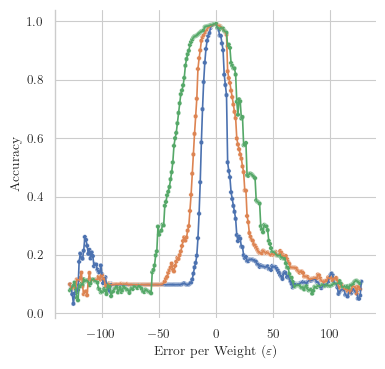

In [4]:
sns.set_theme(context="paper", font="qhv", style="whitegrid", rc={
    "text.usetex" : True,
})

df.columns = df.columns.str.title()
def get_x(y_value: int, point_a, point_b):
    x1, y1 = point_a
    x2, y2 = point_b
    x_hat = None
    if y1 <= y_value <= y2 and y2 <= y_value <= y1:
        m = (y2-y1) / (x2-x1)
        b = y1 - m * x1
        x_hat = (y_value - b) / m
    
    return x_hat
        

def plot_line(g, value, label, color="black"):
    x_min = float("inf")
    x_max = float("-inf")
    ax = g.axes
    for line in g.axes.lines:
        # for line in ax.lines:
        x, y = line.get_data()
        if isinstance(x, list) or x.size == 0 or y.size == 0: continue
        
        for a, b in zip(zip(x[0:-2], y[0:-2]), zip(x[1:], y[1:])):
            x_hat = get_x(value, a, b)
            
            if x_hat is None:
                continue
            
            x_min = min([x_min, x_hat])
            x_max = max([x_max, x_hat])                    
            
    ax.text(x_min, value, f" {x_min:.1f} ({label})", ha="left", va="top", alpha=0.6)
    ax.text(x_max, value, f" {x_max:.1f} ({label})", ha="left", va="top", alpha=0.6)
    ax.axhline(value, linestyle="--", color=color, linewidth=1, alpha=0.75)    
    ax.scatter(x_min, value, color=color, alpha=0.75, marker="x", linewidth=1)
    ax.scatter(x_max, value, color=color, alpha=0.75, marker="x", linewidth=1) 

filtered_df = df.copy()
value_vars = ["Top-1"]
y = "Accuracy"
plot_df = pd.melt(filtered_df, id_vars=["Error", "Error Location"], value_vars=value_vars, var_name="Metric", value_name="Accuracy")

fig, (ax1) = plt.subplots(figsize=(8.27/2, 4))
g1 = sns.lineplot(data=plot_df, x="Error", y=y, hue="Error Location", ax=ax1, legend=False)
sns.scatterplot(data=plot_df, x="Error", y=y, hue="Error Location", s=11, ax=ax1, legend=False)
g1.set(xlabel=r"Error per Weight ($\varepsilon$)")

sns.despine(fig, bottom=True)
plt.show()
fig.savefig(data_store / "lenet.256.error.svg")
fig.savefig(data_store / "lenet.256.error.png")
fig.savefig(data_store / "lenet.256.error.pdf")



c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\matplotlib\transforms.py:354: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


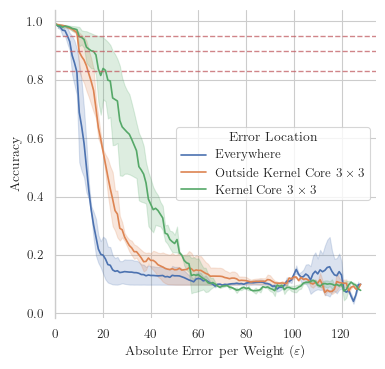

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


In [102]:
plt.clf()
filtered_df = df.copy()
value_vars = ["Top-1"]
y = "Accuracy"

filtered_df["Error"] = np.abs(filtered_df["Error"])

plot_df = pd.melt(filtered_df, id_vars=["Error", "Error Location"], value_vars=value_vars, var_name="Metric", value_name="Accuracy")

fig, (ax1) = plt.subplots(figsize=(8.27/2, 4))
g1 = sns.lineplot(data=plot_df, x="Error", y=y, hue="Error Location", ax=ax1)
g1.set(xlabel=r"Absolute Error per Weight ($\varepsilon$)", xlim=0)
plot_line(g1, 0.95, "0.95", color="#c15c62")
plot_line(g1, 0.9, "0.9", color="#c15c62")
plot_line(g1, 0.83, "0.83", color="#c15c62")

sns.despine(fig, bottom=True)
plt.show()
fig.savefig(data_store / "lenet.256.abs.error.svg")
fig.savefig(data_store / "lenet.256.abs.error.png")
fig.savefig(data_store / "lenet.256.abs.error.pdf")

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

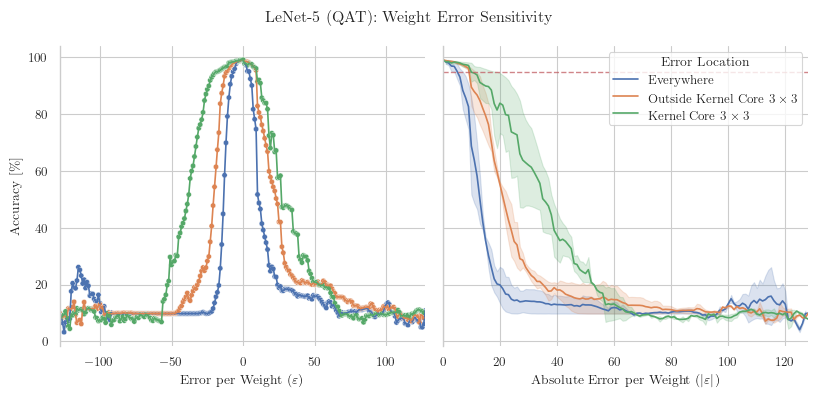

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


In [7]:
filtered_df = df.copy()
value_vars = ["Top-1"]

filtered_df["Abs Error"] = np.abs(filtered_df["Error"])
plot_df = pd.melt(filtered_df, id_vars=["Error", "Abs Error", "Error Location"], value_vars=value_vars, var_name="Metric", value_name="Accuracy")
plot_df["Accuracy"] = plot_df["Accuracy"] * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.27, 4))

g1 = sns.lineplot(data=plot_df, x="Error", y="Accuracy", hue="Error Location", ax=ax1)
sns.scatterplot(data=plot_df, x="Error", y="Accuracy", hue="Error Location", s=15, ax=ax1, legend=False)
g1.set(xlabel=r"Error per Weight ($\varepsilon$)", ylabel=r"Accuracy [$\%$]", xlim=(-128, 127))
ax1.get_legend().remove()

g2 = sns.lineplot(data=plot_df, x="Abs Error", y="Accuracy", hue="Error Location", ax=ax2)
g2.set(xlabel=r"Absolute Error per Weight ($\left|\varepsilon\right|$)", ylabel=None, xlim=(0, 128), yticklabels=[])
# sns.scatterplot(data=plot_df, x="Abs Error", y="Accuracy", hue="Error Location", s=15, ax=ax2, legend=False)
ax2.legend(loc="upper right", title="Error Location")
plot_line(g2, 95, "95", color="#c15c62")
# plot_line(g2, 90, "90", color="#c15c62")
# plot_line(g2, 83, "83", color="#c15c62")

fig.suptitle("LeNet-5 (QAT): Weight Error Sensitivity")
sns.despine(fig, bottom=True)
plt.tight_layout()
plt.show()
fig.savefig(data_store / "lenet.256.all.error.svg")
fig.savefig(data_store / "lenet.256.all.error.png")
fig.savefig(data_store / "lenet.256.all.error.pdf")

In [134]:
table_df = []

for t in filtered_df["Error Location"].unique():

    a_df = filtered_df.loc[(filtered_df["Error Location"] == t) & (filtered_df["Top-1"] >= 0.95), :]
    b_df = filtered_df.loc[(filtered_df["Error Location"] == t) & (filtered_df["Top-1"] >= 0.9) & (filtered_df["Top-1"] < 0.95), :]
    c_df = filtered_df.loc[(filtered_df["Error Location"] == t) & (filtered_df["Top-1"] >= 0.8) & (filtered_df["Top-1"] < 0.9), :]
    d_df = filtered_df.loc[(filtered_df["Error Location"] == t) & (filtered_df["Top-1"] >= 0.7) & (filtered_df["Top-1"] < 0.8), :]
    e_df = filtered_df.loc[(filtered_df["Error Location"] == t) & (filtered_df["Top-1"] >= 0.4) & (filtered_df["Top-1"] < 0.6), :]

    a_df["Error backup"] = a_df["Error"]
    b_df["Error backup"] = b_df["Error"]
    c_df["Error backup"] = c_df["Error"]
    d_df["Error backup"] = d_df["Error"]
    e_df["Error backup"] = e_df["Error"]

    a_min_idx = a_df["Error"].apply(lambda x: abs(x)).idxmax()
    b_min_idx = b_df["Error"].apply(lambda x: abs(x)).idxmax()
    c_min_idx = c_df["Error"].apply(lambda x: abs(x)).idxmax()
    d_min_idx = d_df["Error"].apply(lambda x: abs(x)).idxmax()
    e_min_idx = e_df["Error"].apply(lambda x: abs(x)).idxmax()

    a_min_row = a_df.loc[a_min_idx]
    b_min_row = b_df.loc[b_min_idx]
    c_min_row = c_df.loc[c_min_idx]
    d_min_row = d_df.loc[d_min_idx]
    e_min_row = e_df.loc[e_min_idx]

    table_df.append(pd.DataFrame([a_min_row, b_min_row, c_min_row, d_min_row, e_min_row]))
    # print(a_min_row, b_min_row, c_min_row, d_min_row, e_min_row)
table_df = pd.concat(table_df)
table_df.loc[table_df["Top-1"] >= 0.9, ["Error Location", "Abs Error", "Top-1"]]

C:\Users\Majo\AppData\Local\Temp\ipykernel_3632\3542394936.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_df["Error backup"] = a_df["Error"]
C:\Users\Majo\AppData\Local\Temp\ipykernel_3632\3542394936.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_df["Error backup"] = b_df["Error"]
C:\Users\Majo\AppData\Local\Temp\ipykernel_3632\3542394936.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,Error Location,Abs Error,Top-1
121,Everywhere,7,0.9500
119,Everywhere,9,0.9054
117,Outside Kernel Core $3 \times 3$,11,0.9534
114,Outside Kernel Core $3 \times 3$,14,0.9006
111,Kernel Core $3 \times 3$,17,0.9522
105,Kernel Core $3 \times 3$,23,0.9194
